## Preprocessing and evaluation of the models

This notebook is part of the group project work for the Information System and Big Data. 

The project is about predicting Autism from a given dataset of EEG signals recorded on 19 channels. 
Here we will go through the process of preprocessing the data and training models and their evaluation. All the predictions are made on four features that we managed to extract from the 19 channels (four features are being calculated for each channel).

This project was made by: Simona Nikolovska (104/2020), David Atanasoski (14/2020), Sara Poptodorova (111/2020).

---

### Preprocessing

In [88]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns

# Data processing, modeling, and model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve, accuracy_score, precision_score, recall_score, plot_roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Randomization
import random

from imblearn.over_sampling import SMOTE

Because we are working with time series signals and the readings for every test subject are different (have different time length), we have to divide each reading to be the same length.
We achieve that by creating a Sliding Window that has a fixed length (code below). 

In [89]:
# A method for creating sliding windows
def sliding_window(data, window_size, step_size):
    """
    Inputs:
        data - a 2D numpy array
        window_size - an integer representing the number of samples in a window
        step_size - an integer representing the number of samples between two adjacent windows
    Outputs:
        windows - a 3D numpy array of size (number of windows, window size, number of channels)
    """
    num_samples, num_channels = data.shape
    num_steps = int((num_samples - window_size) / step_size) + 1
    windows = np.zeros((num_steps, window_size, num_channels))

    for step in range(num_steps):
        windows[step] = data[step*step_size:step*step_size+window_size]
    return windows

In [90]:
# This is a method for reading the data from the files and creating a dataframe for each test subject.
def get_dataframe(filename):
    raw = mne.io.read_raw_fif(filename)
    data = raw.get_data()
    return pd.DataFrame(data=data.T, columns=raw.ch_names)

Here we defined the windows size and the step at which we will move the window through the signal. We decided it to be 30 seconds for the best fit. We load file by file and from each file (which represents a test subject), we extract the windows, so every test subject has N windows (or instances). From those instances we extract the four feature - min, max, mead, std for each of the 19 channels. Also, a target is being added for each instance.

For every instance we add file_id that will be used later when we do a test-train split.

In [91]:
WINDOWS_SIZE = 7500 # Equals to 30 seconds (250 samples per second * 30seconds = 7500)
STEP_SIZE = 7500 # Equals to 20 seconds (250 samples per second * 20seconds = 5000), so we have 10 seconds overlap

folders = ['cleaned/Autism', 'cleaned/Normal']

channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4',
                 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6',
                 'Fz', 'Cz', 'Pz']

result_df = pd.DataFrame()

fileId = 0

for folder in folders:

    files = glob.glob(folder + '/*.fif')

    for file in files:

        file_statistics = {
            'file_name': file,
            'file_id': fileId
        }

        if folder == 'cleaned/Autism':
            file_statistics['target'] = 1
        else:
            file_statistics['target'] = 0

        file_df = get_dataframe(file)
        windows = sliding_window(file_df, WINDOWS_SIZE, STEP_SIZE)

        # Convert window to dataframe
        for window in windows:
            window_df = pd.DataFrame(data=window, columns=channel_names)

            min_values = window_df.min(axis=0) # axis=0 means column-wise
            max_values = window_df.max(axis=0)
            mean_values = window_df.mean(axis=0)
            std_values = window_df.std(axis=0)

            for channel, min_value, max_value, mean_value, std_value in zip(channel_names, min_values, max_values, mean_values, std_values):
                file_statistics[channel + '_min'] = min_value
                file_statistics[channel + '_max'] = max_value
                file_statistics[channel + '_mean'] = mean_value
                file_statistics[channel + '_std'] = std_value
            
            file_statistics_df = pd.DataFrame(file_statistics, columns=file_statistics.keys(), index=[0])
            result_df = pd.concat([result_df, file_statistics_df], axis=0, ignore_index=True) # axis=0 to append row here

        fileId += 1

Opening raw data file cleaned/Autism\P001_raw.fif...
    Range : 0 ... 145019 =      0.000 ...   580.076 secs
Ready.
Opening raw data file cleaned/Autism\P002_raw.fif...
    Range : 0 ... 166357 =      0.000 ...   665.428 secs
Ready.
Opening raw data file cleaned/Autism\P003_raw.fif...
    Range : 0 ... 140296 =      0.000 ...   561.184 secs
Ready.
Opening raw data file cleaned/Autism\P004_raw.fif...
    Range : 0 ... 149689 =      0.000 ...   598.756 secs
Ready.
Opening raw data file cleaned/Autism\P005_raw.fif...
    Range : 0 ... 99774 =      0.000 ...   399.096 secs
Ready.
Opening raw data file cleaned/Autism\P006_raw.fif...
    Range : 0 ... 163920 =      0.000 ...   655.680 secs
Ready.
Opening raw data file cleaned/Autism\P007_raw.fif...
    Range : 0 ... 124381 =      0.000 ...   497.524 secs
Ready.
Opening raw data file cleaned/Autism\P008_raw.fif...
    Range : 0 ... 79590 =      0.000 ...   318.360 secs
Ready.
Opening raw data file cleaned/Autism\P009_raw.fif...
    Range : 0

In [92]:
# result_df.to_csv('result.csv', index=False)
result_df

,file_name,file_id,target,Fp1_min,Fp1_max,Fp1_mean,Fp1_std,Fp2_min,Fp2_max,Fp2_mean,...,Fz_mean,Fz_std,Cz_min,Cz_max,Cz_mean,Cz_std,Pz_min,Pz_max,Pz_mean,Pz_std
0,cleaned/Autism\P001_raw.fif,0,1,-138.917618,165.254715,0.359190,27.901689,-95.429581,124.251175,0.126848,...,-0.802674,22.257650,-386.124969,117.571518,0.209703,53.261259,-319.496460,216.207230,-0.850441,68.543451
1,cleaned/Autism\P001_raw.fif,0,1,-132.883652,69.838776,0.061573,20.911264,-67.157356,51.308609,-0.023898,...,-0.033481,20.603490,-178.354431,103.244438,-0.143863,39.585295,-210.421631,112.672478,-0.314277,46.696147
2,cleaned/Autism\P001_raw.fif,0,1,-142.877945,106.720680,-0.138255,26.205421,-86.367325,57.981670,-0.084081,...,0.139161,24.817212,-184.226822,138.967972,-0.011160,52.050263,-288.926239,211.801575,-0.298760,60.908051
3,cleaned/Autism\P001_raw.fif,0,1,-107.867104,86.062317,-0.056258,22.844524,-53.008831,48.473434,-0.091571,...,-0.091892,21.910994,-166.841766,312.431213,0.229130,44.865035,-136.902344,117.115852,0.532895,45.175470
4,cleaned/Autism\P001_raw.fif,0,1,-102.922417,100.598892,0.063023,24.272796,-56.591084,47.551121,0.020538,...,-0.180069,21.384558,-168.205139,121.662338,0.119111,44.298711,-290.595184,190.203400,-0.250603,61.520877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,cleaned/Normal\D09_raw.fif,91,0,-42.867054,34.695118,0.112172,8.175728,-47.517727,54.211807,0.056996,...,0.050273,10.406953,-76.546944,61.467781,0.038129,12.433374,-108.944504,52.716278,0.055415,11.883010
1241,cleaned/Normal\D09_raw.fif,91,0,-33.173904,33.670246,-0.145414,8.318188,-68.125267,50.007500,-0.071947,...,0.117434,9.840449,-52.826950,48.197365,0.273606,12.837473,-56.285099,48.240452,0.218760,12.646260
1242,cleaned/Normal\D09_raw.fif,91,0,-32.838341,38.666626,0.149067,8.786893,-40.051449,60.175743,0.053936,...,-0.399436,10.406983,-58.631813,51.746174,-0.633529,14.798193,-60.959961,46.353233,-0.587135,13.934580
1243,cleaned/Normal\D09_raw.fif,91,0,-34.308651,65.791245,0.477942,8.105535,-129.340042,102.052086,0.240837,...,-0.267244,10.226341,-54.578239,45.409325,-0.324726,12.755623,-56.752861,54.258190,-0.336683,12.601511


In [93]:
result_df.drop('file_name', axis=1, inplace=True)

In [94]:
result_df

,file_id,target,Fp1_min,Fp1_max,Fp1_mean,Fp1_std,Fp2_min,Fp2_max,Fp2_mean,Fp2_std,...,Fz_mean,Fz_std,Cz_min,Cz_max,Cz_mean,Cz_std,Pz_min,Pz_max,Pz_mean,Pz_std
0,0,1,-138.917618,165.254715,0.359190,27.901689,-95.429581,124.251175,0.126848,20.760673,...,-0.802674,22.257650,-386.124969,117.571518,0.209703,53.261259,-319.496460,216.207230,-0.850441,68.543451
1,0,1,-132.883652,69.838776,0.061573,20.911264,-67.157356,51.308609,-0.023898,14.011582,...,-0.033481,20.603490,-178.354431,103.244438,-0.143863,39.585295,-210.421631,112.672478,-0.314277,46.696147
2,0,1,-142.877945,106.720680,-0.138255,26.205421,-86.367325,57.981670,-0.084081,17.275297,...,0.139161,24.817212,-184.226822,138.967972,-0.011160,52.050263,-288.926239,211.801575,-0.298760,60.908051
3,0,1,-107.867104,86.062317,-0.056258,22.844524,-53.008831,48.473434,-0.091571,15.714208,...,-0.091892,21.910994,-166.841766,312.431213,0.229130,44.865035,-136.902344,117.115852,0.532895,45.175470
4,0,1,-102.922417,100.598892,0.063023,24.272796,-56.591084,47.551121,0.020538,15.547879,...,-0.180069,21.384558,-168.205139,121.662338,0.119111,44.298711,-290.595184,190.203400,-0.250603,61.520877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,91,0,-42.867054,34.695118,0.112172,8.175728,-47.517727,54.211807,0.056996,9.920830,...,0.050273,10.406953,-76.546944,61.467781,0.038129,12.433374,-108.944504,52.716278,0.055415,11.883010
1241,91,0,-33.173904,33.670246,-0.145414,8.318188,-68.125267,50.007500,-0.071947,11.632333,...,0.117434,9.840449,-52.826950,48.197365,0.273606,12.837473,-56.285099,48.240452,0.218760,12.646260
1242,91,0,-32.838341,38.666626,0.149067,8.786893,-40.051449,60.175743,0.053936,10.685195,...,-0.399436,10.406983,-58.631813,51.746174,-0.633529,14.798193,-60.959961,46.353233,-0.587135,13.934580
1243,91,0,-34.308651,65.791245,0.477942,8.105535,-129.340042,102.052086,0.240837,10.684182,...,-0.267244,10.226341,-54.578239,45.409325,-0.324726,12.755623,-56.752861,54.258190,-0.336683,12.601511


In [95]:
result_df.describe()

,file_id,target,Fp1_min,Fp1_max,Fp1_mean,Fp1_std,Fp2_min,Fp2_max,Fp2_mean,Fp2_std,...,Fz_mean,Fz_std,Cz_min,Cz_max,Cz_mean,Cz_std,Pz_min,Pz_max,Pz_mean,Pz_std
count,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,...,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000,1245.000000
mean,35.337349,0.808032,-114.765649,120.059137,-0.007756,21.616358,-130.885344,130.413729,0.004177,24.143011,...,0.004362,22.719621,-122.056812,129.552642,-0.007106,24.713322,-139.481423,134.227505,0.007460,26.420168
std,22.775613,0.394006,147.599926,145.691375,0.473278,24.478512,161.143970,167.009383,0.445563,29.195428,...,0.450669,25.033413,137.295221,142.744861,0.386721,24.394306,154.799580,156.469909,0.437680,26.963154
min,0.000000,0.000000,-1408.730347,10.550929,-4.862079,3.240810,-1209.808838,11.549680,-3.458045,3.203425,...,-5.052112,3.137929,-1040.307129,10.705716,-2.685028,3.089587,-1126.505615,15.368500,-2.981258,4.617632
25%,18.000000,1.000000,-135.054077,31.152199,-0.055266,7.902443,-153.202362,32.835140,-0.056788,7.975170,...,-0.056240,8.546050,-140.141006,45.181297,-0.073985,11.361048,-176.093338,46.353233,-0.074144,11.821412
50%,33.000000,1.000000,-55.398052,59.586124,-0.001229,12.312227,-60.633522,61.821461,-0.001913,13.061155,...,0.000215,13.292486,-66.499870,65.873276,-0.002665,15.686640,-70.669640,68.378975,0.000586,16.116660
75%,49.000000,1.000000,-31.584631,148.301437,0.057320,24.332455,-31.930595,152.527283,0.052033,27.104687,...,0.055769,24.791960,-44.097710,156.279999,0.071941,27.273172,-45.384262,155.884247,0.075420,29.107805
max,91.000000,1.000000,-10.629616,1178.944702,4.443395,178.444945,-10.805622,1129.310059,5.245774,245.593719,...,3.310654,169.848720,-11.050933,925.007874,3.312442,198.512944,-14.669809,1238.918091,3.147516,199.250331


In [96]:
result_df.query('target == 1').describe()

,file_id,target,Fp1_min,Fp1_max,Fp1_mean,Fp1_std,Fp2_min,Fp2_max,Fp2_mean,Fp2_std,...,Fz_mean,Fz_std,Cz_min,Cz_max,Cz_mean,Cz_std,Pz_min,Pz_max,Pz_mean,Pz_std
count,1006.000000,1006.0,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,...,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000,1006.000000
mean,26.731610,1.0,-132.093497,139.886474,0.007640,24.792553,-154.542677,153.619068,0.000986,28.200531,...,-0.005735,26.064990,-140.265213,150.284721,0.000142,28.014605,-161.578166,154.210355,-0.004547,29.957215
std,14.976849,0.0,157.923911,154.576298,0.454841,26.165632,170.664307,177.623134,0.476916,31.106669,...,0.422401,26.731613,146.349878,151.242973,0.399754,26.009968,164.053961,166.861770,0.429178,28.807696
min,0.000000,1.0,-1408.730347,15.404556,-4.862079,3.893620,-1209.808838,15.596458,-3.458045,4.627093,...,-2.777677,3.137929,-1040.307129,11.948453,-2.685028,4.369054,-1126.505615,20.441950,-2.981258,5.825166
25%,15.000000,1.0,-159.816826,38.993299,-0.062022,9.020542,-202.681076,42.116931,-0.068998,9.759128,...,-0.069679,9.868441,-177.843212,51.895282,-0.085048,13.448915,-216.780128,53.726665,-0.087765,13.780948
50%,26.500000,1.0,-66.444508,76.524910,-0.000538,14.116250,-82.591015,84.566605,-0.004435,16.075415,...,-0.000005,16.063526,-80.127941,81.501263,-0.002380,17.602588,-87.276859,79.790062,-0.000154,18.185366
75%,40.000000,1.0,-37.185822,185.157066,0.066540,29.463494,-43.681381,181.696751,0.059715,33.304789,...,0.063269,29.960109,-50.248737,192.014084,0.079751,33.526943,-52.407531,193.143993,0.079759,34.474232
max,51.000000,1.0,-12.958858,1178.944702,4.443395,178.444945,-14.709070,1129.310059,5.245774,245.593719,...,3.310654,169.848720,-14.093158,925.007874,3.312442,198.512944,-20.915527,1238.918091,3.147516,199.250331


In [97]:
result_df.query('target == 0').describe()

,file_id,target,Fp1_min,Fp1_max,Fp1_mean,Fp1_std,Fp2_min,Fp2_max,Fp2_mean,Fp2_std,...,Fz_mean,Fz_std,Cz_min,Cz_max,Cz_mean,Cz_std,Pz_min,Pz_max,Pz_mean,Pz_std
count,239.000000,239.0,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,...,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,71.560669,0.0,-41.829183,36.601809,-0.072561,8.247101,-31.306779,32.737699,0.017612,7.064074,...,0.046861,8.638276,-45.413920,42.287074,-0.037612,10.817542,-46.471701,50.115589,0.057999,11.532014
std,11.553469,0.0,44.121956,37.330394,0.540347,4.334443,20.349589,26.581339,0.277495,2.603228,...,0.553104,3.417137,27.996173,21.163995,0.325178,3.705644,29.194397,40.062359,0.469376,4.494626
min,52.000000,0.0,-397.841644,10.550929,-3.571560,3.240810,-169.556763,11.549680,-1.830616,3.203425,...,-5.052112,3.222638,-325.653656,10.705716,-2.168038,3.089587,-353.481964,15.368500,-2.023670,4.617632
25%,62.000000,0.0,-39.857334,22.275415,-0.033441,5.827059,-36.751108,19.330653,-0.022248,5.272078,...,-0.029534,6.502527,-55.171455,29.728311,-0.048249,7.992218,-54.351274,31.275630,-0.040544,8.438654
50%,72.000000,0.0,-29.637297,28.182585,-0.002015,7.113165,-25.250000,25.600807,0.001271,6.564880,...,0.002170,8.239251,-39.393314,39.762470,-0.005778,10.919338,-41.419998,42.286182,0.003724,11.325450
75%,81.500000,0.0,-21.760460,38.581978,0.027110,9.773678,-19.720967,37.588015,0.030662,8.295391,...,0.035623,10.043927,-29.412018,50.561300,0.037510,13.450986,-30.246107,52.903795,0.056596,13.647084
max,91.000000,0.0,-10.629616,489.792999,3.139153,39.483741,-10.805622,326.509613,2.141770,24.719136,...,2.978426,30.084961,-11.050933,241.252045,1.493298,25.183946,-14.669809,389.749695,2.987665,36.843246


In [98]:
# Target distribution
result_df['target'].value_counts()

1    1006
0     239
Name: target, dtype: int64

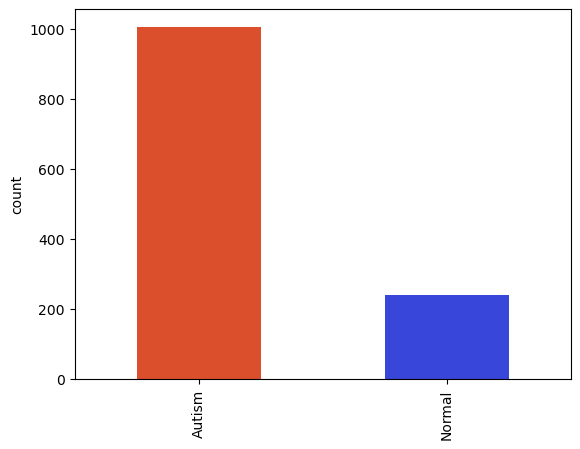

In [99]:
# Plot of the target distribution
result_df['target'].value_counts().plot(kind='bar', color=['#db4f2c', '#3846d9'])
plt.xticks([0,1], ['Autism', 'Normal'])
plt.ylabel('count');

As seen on the previous bar, we can notice that the target classes are imbalanced. So, we decided to apply a oversampling on the minority class using SMOTE (Synthetic Minority Oversampling Technique).

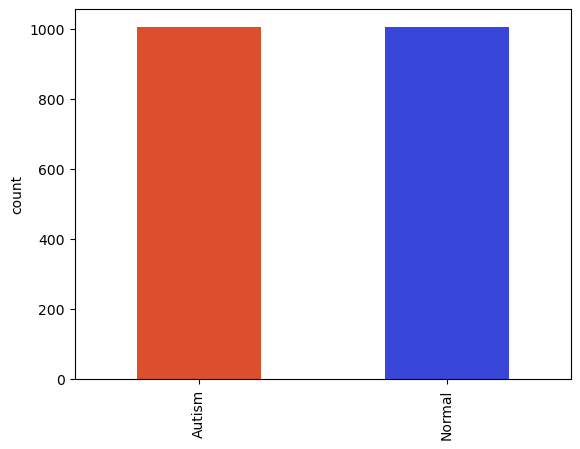

In [100]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)

X = result_df.drop('target', axis=1)
y = result_df['target']

X_smote, y_smote = smote.fit_resample(X, y)

y_smote.value_counts().plot(kind='bar', color=['#db4f2c', '#3846d9'])
plt.xticks([0,1], ['Autism', 'Normal'])
plt.ylabel('count');

In [101]:
# Concatenate X_smote and y_smote and add them to result_df
X_smote_df = pd.DataFrame(data=X_smote, columns=X.columns)
y_smote_df = pd.DataFrame(data=y_smote, columns=['target'])

result_df = pd.concat([X_smote_df, y_smote_df], axis=1)

result_df

,file_id,Fp1_min,Fp1_max,Fp1_mean,Fp1_std,Fp2_min,Fp2_max,Fp2_mean,Fp2_std,F3_min,...,Fz_std,Cz_min,Cz_max,Cz_mean,Cz_std,Pz_min,Pz_max,Pz_mean,Pz_std,target
0,0,-138.917618,165.254715,0.359190,27.901689,-95.429581,124.251175,0.126848,20.760673,-291.603058,...,22.257650,-386.124969,117.571518,0.209703,53.261259,-319.496460,216.207230,-0.850441,68.543451,1
1,0,-132.883652,69.838776,0.061573,20.911264,-67.157356,51.308609,-0.023898,14.011582,-146.079788,...,20.603490,-178.354431,103.244438,-0.143863,39.585295,-210.421631,112.672478,-0.314277,46.696147,1
2,0,-142.877945,106.720680,-0.138255,26.205421,-86.367325,57.981670,-0.084081,17.275297,-138.501923,...,24.817212,-184.226822,138.967972,-0.011160,52.050263,-288.926239,211.801575,-0.298760,60.908051,1
3,0,-107.867104,86.062317,-0.056258,22.844524,-53.008831,48.473434,-0.091571,15.714208,-106.268761,...,21.910994,-166.841766,312.431213,0.229130,44.865035,-136.902344,117.115852,0.532895,45.175470,1
4,0,-102.922417,100.598892,0.063023,24.272796,-56.591084,47.551121,0.020538,15.547879,-112.622749,...,21.384558,-168.205139,121.662338,0.119111,44.298711,-290.595184,190.203400,-0.250603,61.520877,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,59,-27.524902,39.888503,0.034085,7.102893,-37.023003,31.480351,0.016045,7.742954,-46.293254,...,12.424623,-95.588512,70.472287,0.008725,14.867956,-48.975978,50.872256,-0.006412,13.558646,0
2008,55,-23.939230,25.942915,-0.006516,6.810768,-21.499446,21.994604,-0.003282,6.176593,-32.117213,...,6.949165,-54.843511,44.821093,0.012116,14.187663,-44.971338,42.987677,0.014187,14.219725,0
2009,88,-45.992422,64.788457,0.312331,10.245970,-55.587556,54.063257,-0.012032,10.308195,-30.694320,...,11.349682,-74.709654,73.356012,0.125518,13.006228,-125.114539,52.940917,-0.079543,12.920893,0
2010,72,-32.486706,30.527412,-0.006807,7.814258,-17.284549,15.496095,-0.005663,5.027995,-37.107669,...,9.497998,-39.629790,32.708822,-0.014424,10.132328,-46.127318,37.979227,-0.009816,11.020928,0


Here a train-test-split is being done, so the instances of the test subjects are correctly splitted. The instances of one test subject can only belong either in the test or the train set. Instances of one person cannot be found in the two sets.

In [102]:
# Split the data into train and test sets based on file_id
train_ids, test_ids = train_test_split(result_df['file_id'].unique(), test_size=0.3, random_state=1)

train_df = result_df[result_df['file_id'].isin(train_ids)]
test_df = result_df[result_df['file_id'].isin(test_ids)]

# Split the data into train and test
X_train = train_df.drop(['target', 'file_id'], axis=1)
y_train = train_df['target']

X_test = test_df.drop(['target', 'file_id'], axis=1)
y_test = test_df['target']

Standardization of the data is being done.

In [103]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_standardized = pd.DataFrame(data=X_train_scaled, columns=X_train.columns)
X_test_standardized = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)

## Models

1. Dummy Classifier (baseline)
2. Random Forest Classifier
3. KNN Classifier
4. SVM Classifier
5. XGBoost Classifier

In [104]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train_standardized, y_train)

print("Score on test: {}".format(dummy_clf.score(X_test_standardized, y_test)))
print("Score on train: {}".format(dummy_clf.score(X_train_standardized, y_train)))

Score on test: 0.43934426229508194
Score on train: 0.5263908701854494


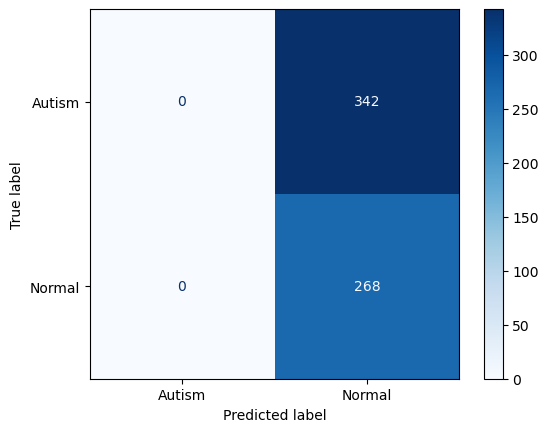

In [105]:
# Plot the confusion matrix with title and score for the test set
plot_confusion_matrix(dummy_clf, X_test_standardized, y_test, cmap='Blues', values_format='d', display_labels=['Autism', 'Normal'], xticks_rotation='horizontal');

In [106]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_standardized, y_train)

print("Score on test: {}".format(rf_clf.score(X_test_standardized, y_test)))
print("Score on train: {}".format(rf_clf.score(X_train_standardized, y_train)))

Score on test: 0.8704918032786885
Score on train: 1.0


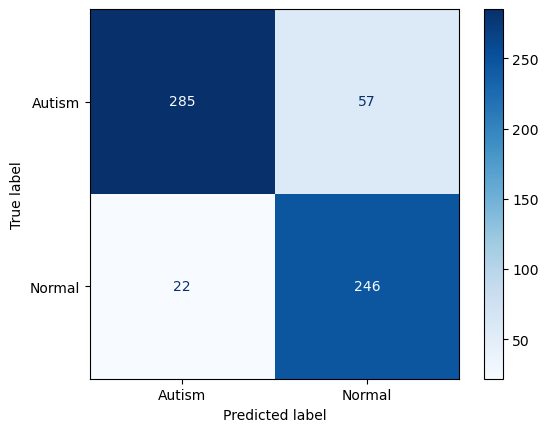

In [107]:
# Plot the confusion matrix
plot_confusion_matrix(rf_clf, X_test_standardized, y_test, cmap='Blues', values_format='d', display_labels=['Autism', 'Normal'], xticks_rotation='horizontal');


In [108]:
# KNN Classifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_standardized, y_train)

print("Score on test: {}".format(knn_clf.score(X_test_standardized, y_test)))
print("Score on train: {}".format(knn_clf.score(X_train_standardized, y_train)))

Score on test: 0.839344262295082
Score on train: 0.9472182596291013


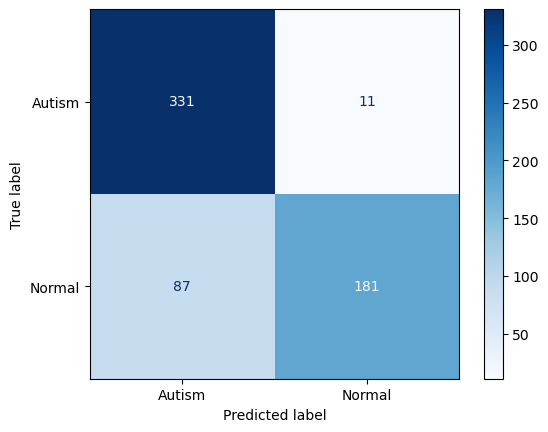

In [109]:
plot_confusion_matrix(knn_clf, X_test_standardized, y_test, cmap='Blues', values_format='d', display_labels=['Autism', 'Normal'], xticks_rotation='horizontal');


In [110]:
svm_clf = SVC()
svm_clf.fit(X_train_standardized, y_train)

print("Score on test: {}".format(svm_clf.score(X_test_standardized, y_test)))
print("Score on train: {}".format(svm_clf.score(X_train_standardized, y_train)))

Score on test: 0.8721311475409836
Score on train: 0.8737517831669044


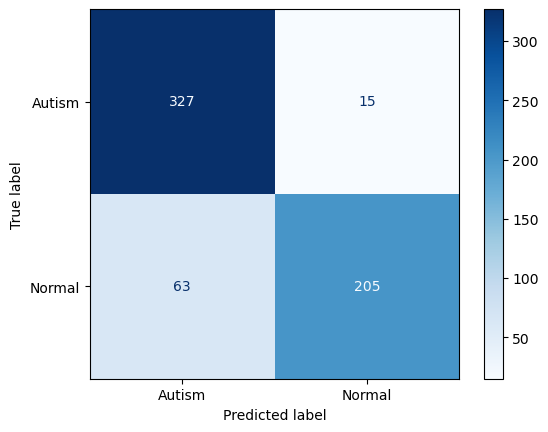

In [111]:
plot_confusion_matrix(svm_clf, X_test_standardized, y_test, cmap='Blues', values_format='d', display_labels=['Autism', 'Normal'], xticks_rotation='horizontal');

In [112]:
# XGBoost Classifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_standardized, y_train)

print("Score on test: {}".format(xgb_clf.score(X_test_standardized, y_test)))
print("Score on train: {}".format(xgb_clf.score(X_train_standardized, y_train)))

Score on test: 0.921311475409836
Score on train: 1.0


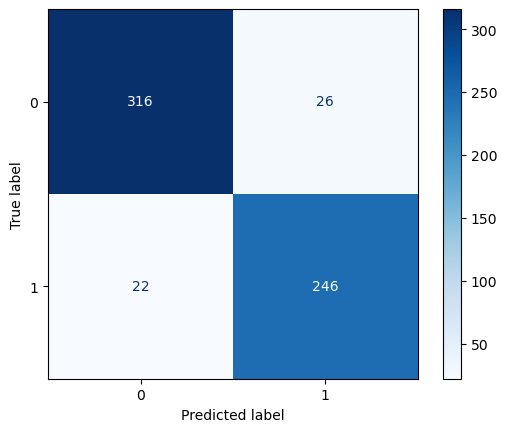

In [113]:
plot_confusion_matrix(xgb_clf, X_test_standardized, y_test, cmap='Blues', values_format='d');

For every model we do metrics and scores analysis. F1, accuracy, precision, recall and auc roc score are being calculated.

As we can see from the comparion dataframe, it's clear the the best model for this project is XGBoost.

In [114]:
# Calculate metrics and scores for each model
dummy_clf_pred = dummy_clf.predict(X_test_standardized)
rf_clf_pred = rf_clf.predict(X_test_standardized)
knn_clf_pred = knn_clf.predict(X_test_standardized)
svm_clf_pred = svm_clf.predict(X_test_standardized)
xgb_clf_pred = xgb_clf.predict(X_test_standardized)

dummy_clf_f1 = f1_score(y_test, dummy_clf_pred)
rf_clf_f1 = f1_score(y_test, rf_clf_pred)
knn_clf_f1 = f1_score(y_test, knn_clf_pred)
svm_clf_f1 = f1_score(y_test, svm_clf_pred)
xgb_clf_f1 = f1_score(y_test, xgb_clf_pred)

dummy_clf_acc = accuracy_score(y_test, dummy_clf_pred)
rf_clf_acc = accuracy_score(y_test, rf_clf_pred)
knn_clf_acc = accuracy_score(y_test, knn_clf_pred)
svm_clf_acc = accuracy_score(y_test, svm_clf_pred)
xgb_clf_acc = accuracy_score(y_test, xgb_clf_pred)

dummy_clf_prec = precision_score(y_test, dummy_clf_pred)
rf_clf_prec = precision_score(y_test, rf_clf_pred)
knn_clf_prec = precision_score(y_test, knn_clf_pred)
svm_clf_prec = precision_score(y_test, svm_clf_pred)
xgb_clf_prec = precision_score(y_test, xgb_clf_pred)

dummy_clf_rec = recall_score(y_test, dummy_clf_pred)
rf_clf_rec = recall_score(y_test, rf_clf_pred)
knn_clf_rec = recall_score(y_test, knn_clf_pred)
svm_clf_rec = recall_score(y_test, svm_clf_pred)
xgb_clf_rec = recall_score(y_test, xgb_clf_pred)

dummy_clf_roc_auc = roc_auc_score(y_test, dummy_clf_pred)
rf_clf_roc_auc = roc_auc_score(y_test, rf_clf_pred)
knn_clf_roc_auc = roc_auc_score(y_test, knn_clf_pred)
svm_clf_roc_auc = roc_auc_score(y_test, svm_clf_pred)
xgb_clf_roc_auc = roc_auc_score(y_test, xgb_clf_pred)

# Create a dataframe with the scores
scores_df = pd.DataFrame({'Model': ['Dummy Classifier', 'Random Forest', 'KNN', 'SVM', 'XGBoost'],
                            'F1 Score': [dummy_clf_f1, rf_clf_f1, knn_clf_f1, svm_clf_f1, xgb_clf_f1],
                            'Accuracy': [dummy_clf_acc, rf_clf_acc, knn_clf_acc, svm_clf_acc, xgb_clf_acc],
                            'Precision': [dummy_clf_prec, rf_clf_prec, knn_clf_prec, svm_clf_prec, xgb_clf_prec],
                            'Recall': [dummy_clf_rec, rf_clf_rec, knn_clf_rec, svm_clf_rec, xgb_clf_rec],
                            'ROC AUC': [dummy_clf_roc_auc, rf_clf_roc_auc, knn_clf_roc_auc, svm_clf_roc_auc, xgb_clf_roc_auc]})
scores_df

,Model,F1 Score,Accuracy,Precision,Recall,ROC AUC
0,Dummy Classifier,0.610478,0.439344,0.439344,1.000000,0.500000
1,Random Forest,0.861646,0.870492,0.811881,0.917910,0.875622
2,KNN,0.786957,0.839344,0.942708,0.675373,0.821605
3,SVM,0.840164,0.872131,0.931818,0.764925,0.860533
4,XGBoost,0.911111,0.921311,0.904412,0.917910,0.920944


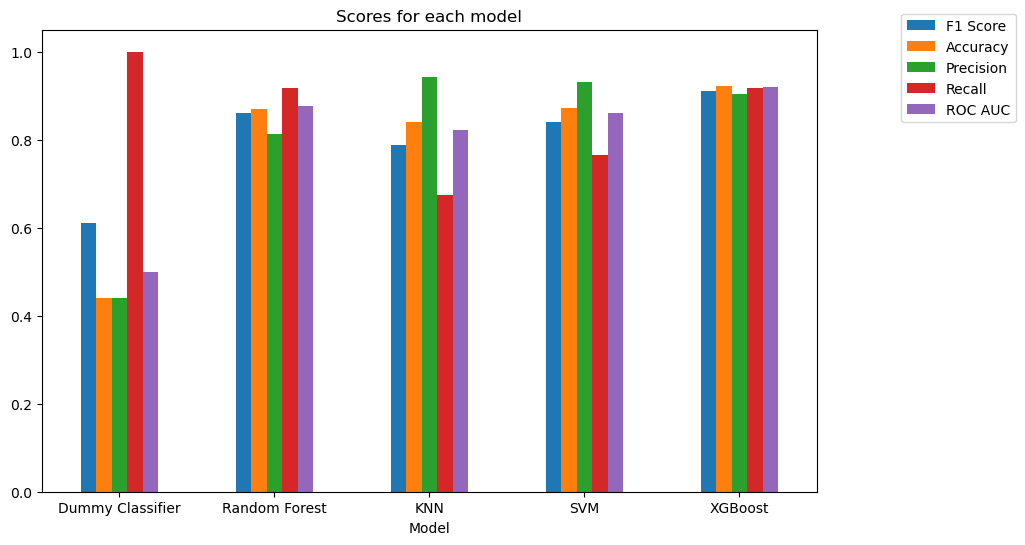

In [115]:
# Plot the scores
fig, ax = plt.subplots(figsize=(10, 6))
scores_df.plot(x='Model', y=['F1 Score', 'Accuracy', 'Precision', 'Recall', 'ROC AUC'], kind='bar', ax=ax)
ax.set_xticklabels(scores_df['Model'], rotation=0)
ax.set_title('Scores for each model')
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

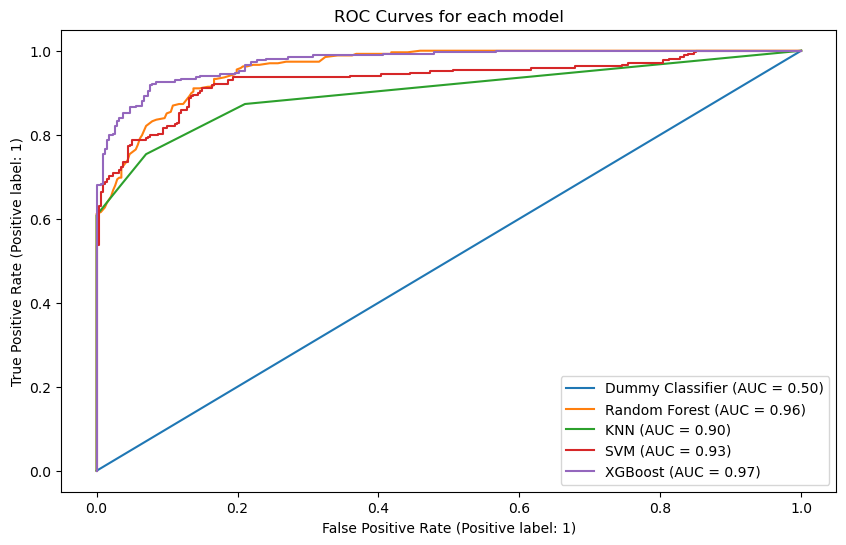

In [116]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_roc_curve(dummy_clf, X_test_standardized, y_test, ax=ax, name='Dummy Classifier')
plot_roc_curve(rf_clf, X_test_standardized, y_test, ax=ax, name='Random Forest')
plot_roc_curve(knn_clf, X_test_standardized, y_test, ax=ax, name='KNN')
plot_roc_curve(svm_clf, X_test_standardized, y_test, ax=ax, name='SVM')
plot_roc_curve(xgb_clf, X_test_standardized, y_test, ax=ax, name='XGBoost')
ax.set_title('ROC Curves for each model')
plt.show()
